# Who Stays and Why? Modeling Employee Retention with Compensation Data

### Background

Studi ini dibuat untuk memahami faktor-faktor yang memengaruhi lamanya seorang karyawan bertahan di perusahaan (*tenure*), terutama dari sisi kompensasi dan pola kerja. Saya menggunakan pendekatan *machine learning* (model *Random Forest*) dan analisis *SHAP* untuk menggambarkan pengaruh berbagai variabel, seperti jenis kompensasi (*traditional* vs *personalized*), *compa ratio*, *benchmark gap*, rotation type, months since last promotion, performance level, hingga work location, terhadap kecenderungan seorang karyawan untuk bertahan atau resign.

In addition to that, Saya juga mensimulasikan tiga skenario retensi yang umum digunakan dalam praktik HR, yaitu:
- **Scenario A**: *Salary adjustment* untuk karyawan dengan *compa ratio* rendah.
- **Scenario B**: Bonus untuk karyawan *underperformer employees* yang belum dipromosikan dalam waktu lama.
- **Scenario C**: Perbaikan kondisi kerja untuk karyawan yang bekerja secara remote atau di jobsite.

### Important Note

Seluruh analisis dilakukan menggunakan data dummy (buatan) yang dirancang khusus untuk simulasi dan pembelajaran. Meskipun tidak mencerminkan kondisi nyata organisasi mana pun, pendekatan dan metodologi ini dapat diterapkan secara langsung pada data aktual untuk mendukung pengambilan keputusan strategis di bidang HR dan compensation planning.

### Executive Summary

Hasil modeling dan simulasi yang dilakukan menunjukan bahwa:

- Karyawan dengan skema kompensasi *personalized* cenderung memiliki *tenure* lebih panjang dibanding yang menerima *traditional pay*.
- Rotation type 6:2 dan jarak promosi yang panjang meningkatkan risiko resign.
- Karyawan dengan *compa ratio* rendah dan performance level rendah lebih rentan untuk resign.
- Dari sisi intervensi:
  - **Scenario C** memiliki dampak paling besar terhadap pengurangan risiko resign dengan biaya yang relatif rendah.
  - **Scenario A** efektif untuk meningkatkan fairness dalam kompensasi, terutama untuk karyawan dengan *pay equity* yang kurang ideal.
  - **Scenario B** berdampak sedang, cocok untuk memotivasi karyawan yang stagnan secara karier.

## Step 1 - Importing necessary libraries

In [486]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

## Step 2 - Load the Data

In [435]:
compensation = pd.read_csv("compensation_model.csv")
compensation

,Unnamed: 0,employee_id,gender,gender_code,employee_age,grade,division,original_division,work_location,original_work_location,...,rotation_type,months_since_last_promotion,months_since_last_lateral_movement,base_salary_idr,annual_bonus_idr,compa_ratio,benchmark_gap_percent_clipped,compensation_type,performance_level,tenure_years
0,0,EMP00001,Female,1,31,C,Technical,Supply Chain,Remote,Mile 74,...,Reguler,55,59,27557000.0,4190000.0,0.83,-16.9,Traditional,3,5.646710
1,1,EMP00002,Male,0,28,6,Technical,Site Operation,Jakarta,Tembagapura,...,6:2,5,29,25051000.0,5087000.0,0.96,-4.3,Personalized,5,7.173120
2,2,EMP00003,Male,0,28,6,Technical,Concentrating,Remote,Surabaya,...,Reguler,48,56,31995000.0,6343000.0,0.96,-3.6,Personalized,4,7.073521
3,3,EMP00004,Male,0,31,E,Operations,Site Operation,Remote,Timika,...,Reguler,54,32,33541000.0,10038000.0,0.91,-8.9,Traditional,3,6.667719
4,4,EMP00005,Female,1,29,4,Operations,Site Operation,Jakarta,Jayapura,...,Reguler,12,38,33568000.0,9382000.0,1.08,7.6,Traditional,2,6.240543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,EMP01996,Female,1,31,D,Operations,Site Operation,Remote,Timika,...,Reguler,41,4,36652000.0,10190000.0,1.04,4.4,Personalized,4,8.966541
1996,1996,EMP01997,Female,1,35,5,HR,Human Capital,Jakarta,Tembagapura,...,6:2,20,16,31168000.0,3642000.0,1.24,24.3,Personalized,5,10.688420
1997,1997,EMP01998,Female,1,26,C,Operations,Site Operation,Jakarta,Jayapura,...,Reguler,3,37,19732000.0,5159000.0,0.91,-9.1,Traditional,1,5.528057
1998,1998,EMP01999,Male,0,30,C,Operations,Concentrating,Jakarta,Mile 74,...,Reguler,24,44,17183000.0,4678000.0,1.02,1.6,Traditional,1,5.127235


In [437]:
compensation_model = compensation.copy()
compensation_model

,Unnamed: 0,employee_id,gender,gender_code,employee_age,grade,division,original_division,work_location,original_work_location,...,rotation_type,months_since_last_promotion,months_since_last_lateral_movement,base_salary_idr,annual_bonus_idr,compa_ratio,benchmark_gap_percent_clipped,compensation_type,performance_level,tenure_years
0,0,EMP00001,Female,1,31,C,Technical,Supply Chain,Remote,Mile 74,...,Reguler,55,59,27557000.0,4190000.0,0.83,-16.9,Traditional,3,5.646710
1,1,EMP00002,Male,0,28,6,Technical,Site Operation,Jakarta,Tembagapura,...,6:2,5,29,25051000.0,5087000.0,0.96,-4.3,Personalized,5,7.173120
2,2,EMP00003,Male,0,28,6,Technical,Concentrating,Remote,Surabaya,...,Reguler,48,56,31995000.0,6343000.0,0.96,-3.6,Personalized,4,7.073521
3,3,EMP00004,Male,0,31,E,Operations,Site Operation,Remote,Timika,...,Reguler,54,32,33541000.0,10038000.0,0.91,-8.9,Traditional,3,6.667719
4,4,EMP00005,Female,1,29,4,Operations,Site Operation,Jakarta,Jayapura,...,Reguler,12,38,33568000.0,9382000.0,1.08,7.6,Traditional,2,6.240543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,EMP01996,Female,1,31,D,Operations,Site Operation,Remote,Timika,...,Reguler,41,4,36652000.0,10190000.0,1.04,4.4,Personalized,4,8.966541
1996,1996,EMP01997,Female,1,35,5,HR,Human Capital,Jakarta,Tembagapura,...,6:2,20,16,31168000.0,3642000.0,1.24,24.3,Personalized,5,10.688420
1997,1997,EMP01998,Female,1,26,C,Operations,Site Operation,Jakarta,Jayapura,...,Reguler,3,37,19732000.0,5159000.0,0.91,-9.1,Traditional,1,5.528057
1998,1998,EMP01999,Male,0,30,C,Operations,Concentrating,Jakarta,Mile 74,...,Reguler,24,44,17183000.0,4678000.0,1.02,1.6,Traditional,1,5.127235


## Step 3: Exploratory Data Analysis

In [266]:
print("Shape:", compensation_model.shape)
print("Missing values:\n", compensation_model.isnull().sum())
print("Data types:\n", compensation_model.dtypes)

Shape: (2000, 21)
Missing values:
 Unnamed: 0                            0
employee_id                           0
gender                                0
gender_code                           0
employee_age                          0
grade                                 0
division                              0
original_division                     0
work_location                         0
original_work_location                0
accommodation_type                    0
rotation_type                         0
months_since_last_promotion           0
months_since_last_lateral_movement    0
base_salary_idr                       0
annual_bonus_idr                      0
compa_ratio                           0
benchmark_gap_percent_clipped         0
compensation_type                     0
performance_level                     0
tenure_years                          0
dtype: int64
Data types:
 Unnamed: 0                              int64
employee_id                            object
gender 

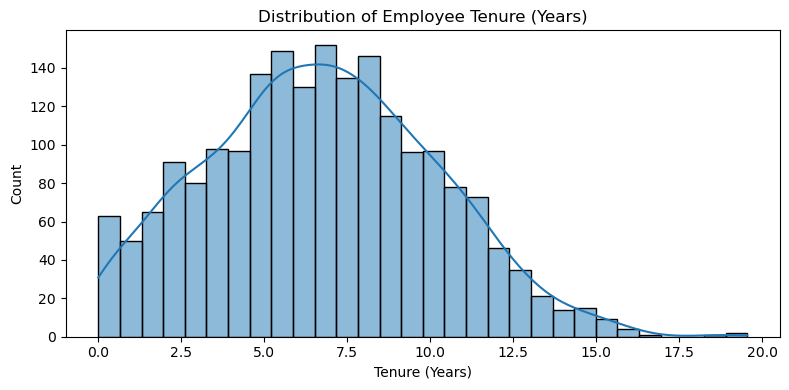

In [268]:
plt.figure(figsize=(8, 4))
sns.histplot(compensation_model["tenure_years"], bins=30, kde=True)
plt.title("Distribution of Employee Tenure (Years)")
plt.xlabel("Tenure (Years)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Histogram di atas menunjukan bahwa distribusi *tenure* (masa kerja)
cenderung berpola *right-skewed*, di mana sebagian besar karyawan memiliki masa kerja antara 
**5 hingga 10 tahun**. Puncaknya berada pada rentang **7–8 tahun**, yang menjadi durasi paling umum 
bagi karyawan untuk bertahan di perusahaan. Setelah melewati 10 tahun, jumlah karyawan mulai menurun, 
menunjukkan bahwa *long-term retention* relatif lebih rendah. Hanya sedikit karyawan yang bertahan 
lebih dari 15 tahun. Pola ini mencerminkan dinamika umum di banyak organisasi, dan memperkuat urgensi 
bagi tim HR untuk merancang strategi retensi yang lebih tepat sasaran, terutama bagi karyawan dengan 
masa kerja yang sudah cukup panjang.

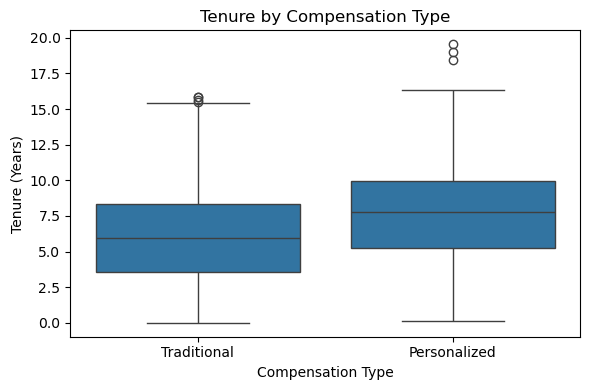

In [272]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=compensation_model, x="compensation_type", y="tenure_years")
plt.title("Tenure by Compensation Type")
plt.xlabel("Compensation Type")
plt.ylabel("Tenure (Years)")
plt.tight_layout()
plt.show()

Berdasarkan visualisasi di atas, terlihat bahwa karyawan dengan skema kompensasi *personalized* 
memiliki **tenure** (masa kerja) yang cenderung lebih panjang dibandingkan dengan mereka yang menerima 
kompensasi *traditional*. Median *tenure* untuk kelompok *personalized* lebih tinggi, dan sebaran datanya 
juga menunjukkan adanya lebih banyak karyawan yang bertahan dalam jangka panjang. 
Temuan ini memperkuat hipotesis bahwa pemberian kompensasi yang disesuaikan dengan kebutuhan atau preferensi 
individu dapat meningkatkan *retention* karyawan dalam jangka menengah hingga panjang.

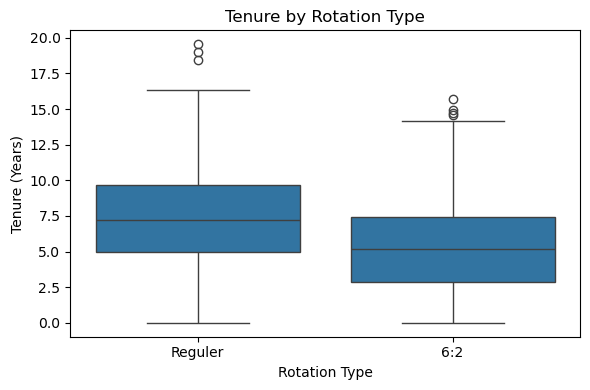

In [274]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=compensation_model, x="rotation_type", y="tenure_years")
plt.title("Tenure by Rotation Type")
plt.xlabel("Rotation Type")
plt.ylabel("Tenure (Years)")
plt.tight_layout()
plt.show()

Berdasarkan visualisasi di atas, terlihat bahwa karyawan dengan *rotation type* **Reguler** 
memiliki *tenure* (masa kerja) yang lebih panjang dibandingkan dengan mereka yang bekerja 
dengan skema rotasi **6:2**. Median *tenure* pada kelompok Reguler lebih tinggi, dan distribusi 
datanya juga menunjukkan persebaran masa kerja yang lebih stabil dan panjang. 
Sebaliknya, pada kelompok 6:2, masa kerja cenderung lebih pendek dengan persebaran yang lebih sempit. 
Temuan ini mendukung hipotesis bahwa pola kerja Reguler lebih kondusif terhadap 
*retention*, kemungkinan karena menawarkan stabilitas dan keseimbangan kerja-kehidupan yang lebih baik.

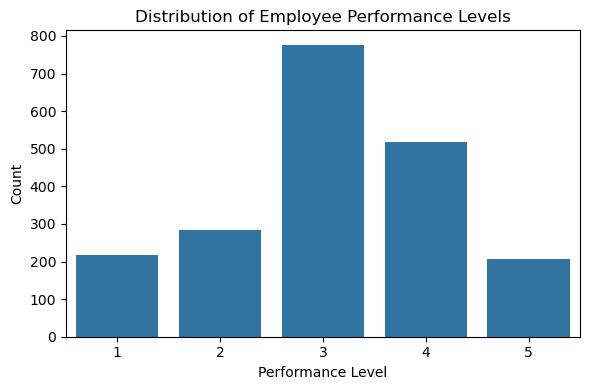

In [222]:
plt.figure(figsize=(6, 4))
sns.countplot(data=compensation_model, x="performance_level", order=sorted(compensation_model["performance_level"].unique()))
plt.title("Distribution of Employee Performance Levels")
plt.xlabel("Performance Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Bar Chart di atas menunjukkan distribusi tingkat kinerja karyawan (*performance level*) yang terbagi 
dalam lima kategori, dari level 1 (terendah) hingga level 5 (tertinggi). Mayoritas karyawan berada 
pada level 3 dan 4, yang mencerminkan performa standar hingga di atas rata-rata.

Distribusi ini menyerupai pola *bell-shaped*, di mana sebagian besar karyawan berkinerja cukup baik, 
sementara hanya sebagian kecil yang berada di level 1 dan 5. Hal ini dapat mencerminkan sistem evaluasi 
yang realistis dan tidak ekstrem, sekaligus memberi ruang untuk pengembangan karyawan berkinerja rendah 
dan pemberian apresiasi untuk mereka yang berkinerja sangat tinggi.

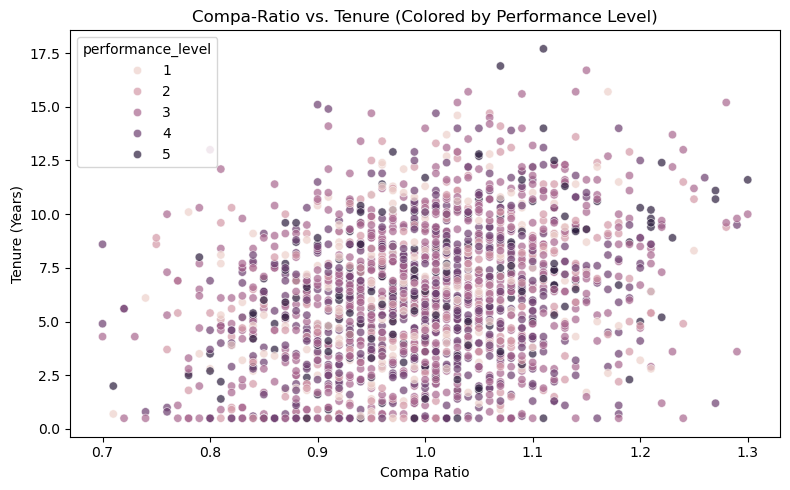

In [224]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=compensation_model, x="compa_ratio", y="tenure_years", hue="performance_level", alpha=0.7)
plt.title("Compa-Ratio vs. Tenure (Colored by Performance Level)")
plt.xlabel("Compa Ratio")
plt.ylabel("Tenure (Years)")
plt.tight_layout()
plt.show()

Grafik di atas menggambarkan hubungan antara *compa-ratio* dan *tenure* (masa kerja) karyawan, 
dengan titik-titik yang diwarnai berdasarkan *performance level*. Secara umum, terlihat adanya kecenderungan 
bahwa karyawan dengan *compa-ratio* yang lebih tinggi, artinya gaji mereka relatif lebih kompetitif 
dibandingkan rata-rata internal, cenderung memiliki *tenure* yang lebih panjang.


Distribusinya juga menunjukkan bahwa karyawan dengan *performance level* yang lebih tinggi (warna lebih gelap) 
lebih banyak berada pada kombinasi *compa-ratio* tinggi dan masa kerja panjang. 
Hal ini mengindikasikan bahwa memberikan kompensasi yang kompetitif bukan hanya dapat meningkatkan retensi, 
tetapi juga dapat mendukung keberlangsungan karyawan berkinerja tinggi.

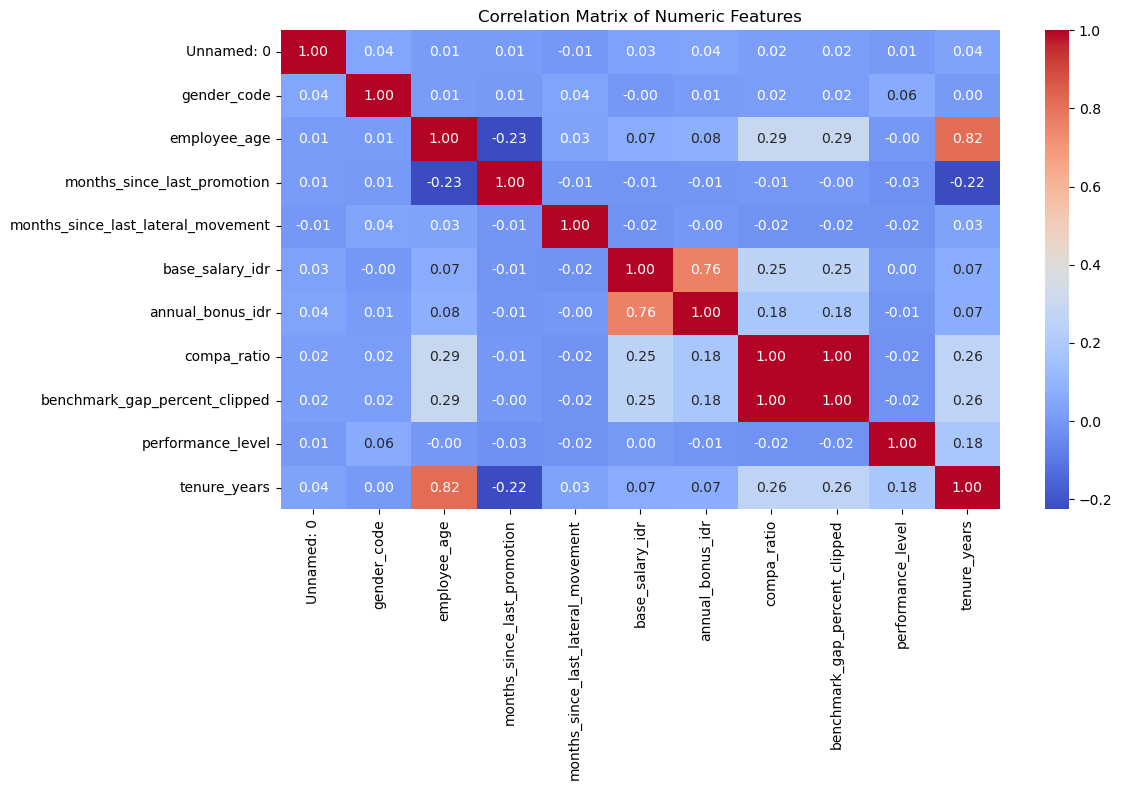

In [276]:
numeric_cols = compensation_model.select_dtypes(include=["float64", "int64"]).drop(columns=["employee_id"], errors='ignore')
corr = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

Berdasarkan *correlation matrix* di atas, terlihat bahwa variabel *employee_age* memiliki korelasi yang sangat kuat dengan *tenure_years* (r = 0.82), Hal ini logis karena usia yang lebih tinggi umumnya berkorelasi dengan masa kerja yang lebih panjang.

Variabel *compa_ratio* dan *benchmark_gap_percent_clipped* juga menunjukkan korelasi positif sedang 
dengan *tenure_years* (r = 0.26), yang memperkuat temuan bahwa kompensasi yang lebih kompetitif 
berkaitan dengan tingkat retensi yang lebih tinggi. Sebaliknya, *months_since_last_promotion* memiliki 
korelasi negatif (r = -0.22), yang mengindikasikan bahwa semakin lama seseorang tidak dipromosikan, 
semakin besar kemungkinan ia meninggalkan organisasi.

Korelasi antar komponen kompensasi seperti 
*base_salary_idr* dan *annual_bonus_idr* juga tinggi (r = 0.76), menunjukkan hubungan linier yang konsisten 
dalam struktur gaji.

## Step 4: Data Modeling & Result

In [366]:
df = pd.read_csv("compensation_model.csv")

df_model = pd.get_dummies(df, columns=[
    "rotation_type", "compensation_type", "accommodation_type", "division", "work_location", "grade"
], drop_first=True)

features = [
    "compa_ratio", "benchmark_gap_percent_clipped",
    "months_since_last_promotion", "months_since_last_lateral_movement"
] + [col for col in df_model.columns if col.startswith(
    ("rotation_type_", "compensation_type", "accommodation_type_", "division_", "work_location_")
)]

X = df_model[features]
y = df_model["tenure_years"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R² Score: 0.3854071332303216
MAE: 2.1939581236499532


Nilai **R² sebesar 0.385** menunjukkan bahwa model mampu menjelaskan sekitar 38.5% variasi dalam 
*tenure* (masa kerja) karyawan berdasarkan fitur-fitur yang digunakan, seperti *compa ratio*, 
jenis kompensasi, rotasi kerja, dan riwayat promosi. Meskipun bukan nilai yang sangat tinggi, 
hasil ini tetap memberikan sinyal bahwa variabel-variabel tersebut memiliki pengaruh yang cukup signifikan 
terhadap retensi karyawan. Sementara itu, nilai **MAE sebesar 2.19 tahun** berarti rata-rata kesalahan 
prediksi model hanya sekitar 2 tahun, yang relatif wajar dalam konteks prediksi masa kerja. 
Model ini dapat menjadi alat bantu awal untuk mengidentifikasi kelompok karyawan dengan risiko retensi 
yang lebih rendah atau tinggi.

### 4.1: Sample Prediction

In [298]:
sample_df = pd.DataFrame({
    "Actual Tenure": y_test,
    "Predicted Tenure": y_pred
}).reset_index(drop=True)

print("\nSample Predictions:")
print(sample_df.head())


Sample Predictions:
   Actual Tenure  Predicted Tenure
0      13.291553         10.337379
1       4.277972          4.084320
2      11.000270          9.665826
3       7.239405          8.036483
4       0.575695          3.035162


Contoh prediksi di atas menunjukkan hasil estimasi model terhadap *tenure* (masa kerja) karyawan. 
Secara umum, prediksi berada cukup dekat dengan nilai aktual. Sebagai contoh, pada baris pertama, 
karyawan dengan masa kerja aktual sekitar **13.29 tahun** diprediksi memiliki *tenure* sebesar **10.34 tahun**, 
sementara pada baris kedua prediksi hanya meleset sekitar **0.2 tahun** dari nilai sebenarnya. 
Ini mengindikasikan bahwa model cukup mampu memberikan estimasi yang mendekati realita, 
meskipun dalam beberapa kasus perbedaan bisa mencapai 2–3 tahun. 
Output ini bermanfaat sebagai *sanity check* untuk memahami bagaimana model bekerja 
dalam kasus-kasus individual sebelum digunakan dalam skala yang lebih luas.

## Step 5: Anaysis of Features Importance

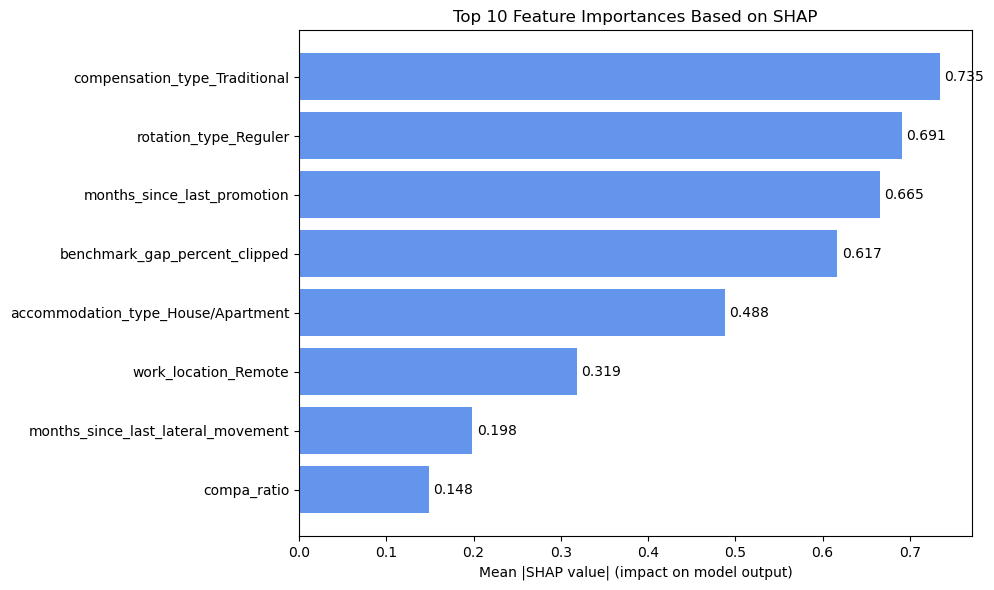

In [314]:
categorical_cols = ["rotation_type", "compensation_type", "accommodation_type", "work_location"]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df_encoded[[
    "compa_ratio", "benchmark_gap_percent_clipped",
    "months_since_last_promotion", "months_since_last_lateral_movement"
] + [col for col in df_encoded.columns if col.startswith((
    "rotation_type_", "compensation_type_", "accommodation_type_", "work_location_"))]]

y = df_encoded["tenure_years"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': shap_importance
}).sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['feature'], importance_df['importance'], color='cornflowerblue')
plt.xlabel("Mean |SHAP value| (impact on model output)")
plt.title("Top 10 Feature Importances Based on SHAP")

for bar in bars:
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Grafik di atas menunjukkan 8 fitur teratas yang paling berpengaruh terhadap prediksi
masa kerja berdasarkan nilai *SHAP* (SHapley Additive Explanations). Fitur dengan pengaruh tertinggi 
adalah **compensation_type_Traditional**, yang mengindikasikan bahwa jenis kompensasi traditional memiliki dampak signifikan  terhadap retensi—di mana karyawan dengan skema *personalized* cenderung memiliki *tenure* yang lebih panjang (jika *Traditional* bernilai 1, artinya *Personalized* adalah baseline). Fitur penting lainnya meliputi 
**rotation_type_Reguler**, **months_since_last_promotion**, dan **benchmark_gap_percent_clipped**, 
yang masing-masing mencerminkan stabilitas pola kerja, peluang kenaikan jabatan, dan kesenjangan gaji terhadap 
benchmark pasar. Temuan ini menunjukkan bahwa strategi kompensasi dan pengembangan karier yang adil serta 
kondisi kerja yang stabil sangat berkontribusi terhadap panjangnya masa kerja karyawan.

## Conclusion

Dari hasil analisis yang dilakukan, kita bisa melihat bahwa beberapa faktor memang punya pengaruh cukup besar 
terhadap lamanya seorang karyawan bertahan di perusahaan (*tenure*). Model yang digunakan membantu kita 
melihat pola secara lebih objektif dan *data-driven*, terutama dalam hal kompensasi dan pengaturan kerja.

Beberapa hal penting yang bisa dicatat:

- Karyawan dengan kompensasi **personalized** cenderung memiliki masa kerja yang lebih panjang 
  dibandingkan yang menerima skema **traditional**.
- Pola kerja **reguler** lebih stabil dan berkaitan dengan retensi yang lebih baik dibanding sistem rotasi 6:2.
- Karyawan yang sudah lama tidak dipromosikan cenderung memiliki masa kerja yang lebih pendek.
- Kompensasi yang kompetitif (dilihat dari **compa ratio** dan **benchmark gap**) juga berdampak positif 
  terhadap retensi.
- Secara umum, karyawan dengan performa tinggi seringkali muncul di kelompok dengan gaji yang lebih sesuai 
  dan masa kerja yang lebih panjang.

Hasil ini menunjukkan bahwa strategi kompensasi dan karier yang adil dan relevan bukan hanya membantu 
menjaga talenta, tapi juga menciptakan lingkungan kerja yang lebih sehat dan berkelanjutan.

# PART 2: Retention Offer Scenario Analysis

Di bagian ini, saya menganalisis beberapa skenario **retention offer** untuk melihat dampaknya terhadap **resignation risk**. Saya mensimulasikan intervensi seperti menaikkan **base salary** bagi karyawan dengan **low compa-ratio**, memberikan **bonus** kepada karyawan dengan **low performance** yang sudah lama tidak dipromosikan, dan memperbaiki kondisi kerja bagi yang bekerja di lokasi **remote**. Tujuannya adalah untuk memahami sejauh mana intervensi ini dapat menurunkan **resignation risk** dan apakah secara **cost-benefit** layak untuk dijalankan.

In [439]:
def simulate_resignation_prob(row):
    prob = 0.1  # base probability

    prob += 0.15 if row['months_since_last_promotion'] > 48 else 0
    prob += 0.15 if row['performance_level'] <= 2 else 0
    prob += 0.2 if row['compa_ratio'] < 0.9 else 0
    prob += 0.1 if row['rotation_type'] == '6:2' else 0
    prob += 0.1 if row['work_location'] == 'Remote' else 0

    return 1 if np.random.rand() < min(prob, 0.9) else 0

compensation_model['resigned'] = compensation_model.apply(simulate_resignation_prob, axis=1)

### Simulasi Resign Karyawan Berdasarkan Faktor Risiko

Dalam bagian ini, saya mencoba mensimulasikan probabilitas karyawan untuk resign dengan mempertimbangkan beberapa faktor yang seringkali memengaruhi keputusan mereka. Misalnya, apakah mereka sudah lama tidak dipromosikan, performanya rendah, atau gajinya di bawah *benchmark* (*compa ratio* rendah). Saya juga mempertimbangkan faktor-faktor seperti jenis rotasi kerja (misalnya 6:2) dan lokasi kerja yang jauh (jobsite), karena kondisi-kondisi tersebut biasanya lebih berat dan bisa mendorong keinginan untuk keluar.

Setiap faktor saya beri bobot risiko tertentu, lalu saya kombinasikan untuk menghitung kemungkinan seorang karyawan *resign*. Hasil akhirnya adalah variabel `resigned`, yang saya gunakan sebagai dasar untuk menganalisis skenario retensi. Tujuannya, agar kita bisa lihat bagaimana perubahan kebijakan kompensasi bisa menurunkan risiko resign di kelompok tertentu.

In [441]:
compensation_model.head()

,Unnamed: 0,employee_id,gender,gender_code,employee_age,grade,division,original_division,work_location,original_work_location,...,months_since_last_promotion,months_since_last_lateral_movement,base_salary_idr,annual_bonus_idr,compa_ratio,benchmark_gap_percent_clipped,compensation_type,performance_level,tenure_years,resigned
0,0,EMP00001,Female,1,31,C,Technical,Supply Chain,Remote,Mile 74,...,55,59,27557000.0,4190000.0,0.83,-16.9,Traditional,3,5.646710,0
1,1,EMP00002,Male,0,28,6,Technical,Site Operation,Jakarta,Tembagapura,...,5,29,25051000.0,5087000.0,0.96,-4.3,Personalized,5,7.173120,0
2,2,EMP00003,Male,0,28,6,Technical,Concentrating,Remote,Surabaya,...,48,56,31995000.0,6343000.0,0.96,-3.6,Personalized,4,7.073521,0
3,3,EMP00004,Male,0,31,E,Operations,Site Operation,Remote,Timika,...,54,32,33541000.0,10038000.0,0.91,-8.9,Traditional,3,6.667719,0
4,4,EMP00005,Female,1,29,4,Operations,Site Operation,Jakarta,Jayapura,...,12,38,33568000.0,9382000.0,1.08,7.6,Traditional,2,6.240543,1


In [447]:
### Scenario A: Salary adjustment for low compa_ratio
compensation_model['scenario_A_resigned'] = df.apply(
    lambda row: 0 if row['resigned'] == 1 and row['compa_ratio'] < 0.9 else row['resigned'],
    axis=1)

### Scenario B: Bonus to underperformers with long time since promotion
compensation_model['scenario_B_resigned'] = df.apply(
    lambda row: 0 if row['resigned'] == 1 and row['performance_level'] <= 2 and row['months_since_last_promotion'] > 48 else row['resigned'],
    axis=1)

### Scenario C: Improve condition for remote workers
compensation_model['scenario_C_resigned'] = df.apply(
    lambda row: 0 if row['resigned'] == 1 and row['work_location'] == 'Remote' else row['resigned'],
    axis=1)

print(df.head())

   Unnamed: 0 employee_id  gender  gender_code  employee_age grade  \
0           0    EMP00001  Female            1            31     C   
1           1    EMP00002    Male            0            28     6   
2           2    EMP00003    Male            0            28     6   
3           3    EMP00004    Male            0            31     E   
4           4    EMP00005  Female            1            29     4   

     division original_division work_location original_work_location  ...  \
0   Technical      Supply Chain        Remote                Mile 74  ...   
1   Technical    Site Operation       Jakarta            Tembagapura  ...   
2   Technical     Concentrating        Remote               Surabaya  ...   
3  Operations    Site Operation        Remote                 Timika  ...   
4  Operations    Site Operation       Jakarta               Jayapura  ...   

  performance_level tenure_years  resigned  scenario_A_prob  scenario_B_prob  \
0                 3     5.646710    

### Retention Offer Scenario Simulation

Setelah mensimulasikan siapa saja yang berisiko resign, saya lanjutkan dengan membuat beberapa skenario intervensi (retention offer) untuk melihat potensi dampaknya terhadap penurunan risiko resign. Setiap skenario mewakili kebijakan berbeda yang mungkin dilakukan oleh perusahaan.

#### Scenario A: *Salary Adjustment* untuk Karyawan dengan Compa Ratio Rendah
Dalam skenario ini, diasumsikan bahwa jika karyawan yang berisiko resign dan memiliki **compa ratio di bawah 0.9** diberikan penyesuaian gaji, maka mereka akan **memutuskan untuk tetap bertahan**. Oleh karena itu, nilai `resigned` untuk karyawan tersebut diubah dari 1 menjadi 0.

#### Scenario B: Bonus untuk *Underperformer* yang Sudah Lama Tidak Dipromosikan
Untuk karyawan dengan performa rendah (**performance level ≤ 2**) dan sudah lebih dari **48 bulan sejak promosi terakhir**, diberikan insentif berupa bonus. Diharapkan insentif ini cukup untuk mencegah mereka resign. Jadi, jika mereka sebelumnya 'resigned', statusnya diubah menjadi 0.

#### Scenario C: Perbaikan Kondisi Kerja untuk *Remote Workers*
Bagi karyawan yang bekerja di lokasi **Remote**, diasumsikan bahwa peningkatan kondisi kerja (misalnya: fasilitas, fleksibilitas, atau insentif lokasi) bisa membuat mereka bertahan. Jadi, `resigned` mereka juga diubah menjadi 0 dalam skenario ini.

#### Tujuan
Ketiga skenario ini digunakan untuk:
- **Menguji efektivitas kebijakan retensi tertentu**
- **Melihat pengaruh langsung dari intervensi terhadap kelompok berisiko**
- **Membandingkan outcome tiap skenario secara kuantitatif**

Dengan pendekatan ini, kita bisa lebih terarah dalam menentukan kebijakan kompensasi yang strategis dan berdampak.

In [449]:
compensation_model

,Unnamed: 0,employee_id,gender,gender_code,employee_age,grade,division,original_division,work_location,original_work_location,...,annual_bonus_idr,compa_ratio,benchmark_gap_percent_clipped,compensation_type,performance_level,tenure_years,resigned,scenario_A_resigned,scenario_B_resigned,scenario_C_resigned
0,0,EMP00001,Female,1,31,C,Technical,Supply Chain,Remote,Mile 74,...,4190000.0,0.83,-16.9,Traditional,3,5.646710,0,0,1,0
1,1,EMP00002,Male,0,28,6,Technical,Site Operation,Jakarta,Tembagapura,...,5087000.0,0.96,-4.3,Personalized,5,7.173120,0,0,0,0
2,2,EMP00003,Male,0,28,6,Technical,Concentrating,Remote,Surabaya,...,6343000.0,0.96,-3.6,Personalized,4,7.073521,0,0,0,0
3,3,EMP00004,Male,0,31,E,Operations,Site Operation,Remote,Timika,...,10038000.0,0.91,-8.9,Traditional,3,6.667719,0,0,0,0
4,4,EMP00005,Female,1,29,4,Operations,Site Operation,Jakarta,Jayapura,...,9382000.0,1.08,7.6,Traditional,2,6.240543,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,EMP01996,Female,1,31,D,Operations,Site Operation,Remote,Timika,...,10190000.0,1.04,4.4,Personalized,4,8.966541,0,0,0,0
1996,1996,EMP01997,Female,1,35,5,HR,Human Capital,Jakarta,Tembagapura,...,3642000.0,1.24,24.3,Personalized,5,10.688420,0,0,0,0
1997,1997,EMP01998,Female,1,26,C,Operations,Site Operation,Jakarta,Jayapura,...,5159000.0,0.91,-9.1,Traditional,1,5.528057,0,0,0,0
1998,1998,EMP01999,Male,0,30,C,Operations,Concentrating,Jakarta,Mile 74,...,4678000.0,1.02,1.6,Traditional,1,5.127235,0,0,0,0


In [453]:
# Original resignation rate
baseline_rate = df['resigned'].mean()

# After Scenario A
scenario_A_rate = df['scenario_A_resigned'].mean()

# After Scenario B
scenario_B_rate = df['scenario_B_resigned'].mean()

# After Scenario C
scenario_C_rate = df['scenario_C_resigned'].mean()

print("Baseline resignation rate:", baseline_rate)
print("Scenario A resignation rate:", scenario_A_rate)
print("Scenario B resignation rate:", scenario_B_rate)
print("Scenario C resignation rate:", scenario_C_rate)

Baseline resignation rate: 0.2625
Scenario A resignation rate: 0.2095
Scenario B resignation rate: 0.237
Scenario C resignation rate: 0.1305


### Impact Analysis of Retention Offer terhadap Resignation Rate

Berdasarkan simulasi awal, **baseline resignation rate** tercatat sebesar **26.25%**. Artinya, tanpa adanya intervensi apa pun, sekitar 26 dari setiap 100 karyawan diprediksi akan resign berdasarkan kombinasi faktor risiko seperti gaji rendah (low compa-ratio), performa rendah, lama tidak dipromosikan, jenis rotasi kerja, atau lokasi kerja yang jauh.

Setelah diterapkan masing-masing skenario retensi, terlihat adanya penurunan tingkat resign sebagai berikut:

- **Scenario A** – *Salary adjustment* untuk karyawan dengan compa-ratio rendah:  
  Resignation rate turun menjadi **20.95%**.

- **Scenario B** – Bonus untuk *underperformer* yang lama tidak dipromosikan:  
  Resignation rate turun menjadi **23.7%**.

- **Scenario C** – Perbaikan kondisi kerja bagi karyawan remote:  
  Memberikan dampak paling signifikan dengan menurunkan resignation rate ke **13.05%**.

### Insight:
Hasil ini menunjukkan bahwa **Scenario C** memberikan efek paling kuat dalam menurunkan risiko resign, disusul oleh Scenario A dan B. Ini bisa menjadi bahan pertimbangan strategis bagi tim HR untuk mulai fokus pada intervensi berbasis lokasi kerja, seperti peningkatan fasilitas, rotasi, atau dukungan tambahan bagi karyawan di lokasi remote sebagai langkah retensi yang lebih berdampak.

In [473]:
compensation_model.groupby('performance_level')[['resigned', 'scenario_A_resigned', 'scenario_B_resigned', 'scenario_C_resigned']].mean()

,resigned,scenario_A_resigned,scenario_B_resigned,scenario_C_resigned
performance_level,,,,
1,0.296296,0.268519,0.236111,0.138889
2,0.408360,0.337621,0.321543,0.221865
3,0.231266,0.189922,0.229974,0.118863
4,0.201195,0.161355,0.221116,0.101594
5,0.197970,0.142132,0.172589,0.096447


### Analysis by Performance Level:

- **Karyawan dengan performa rendah (Level 1 & 2)** memiliki tingkat risiko resign yang paling tinggi, dan mereka paling banyak terbantu oleh **Scenario B** (bonus untuk yang lama tidak dipromosikan) dan **Scenario C** (perbaikan kondisi kerja).
- **Scenario C consistently memberikan dampak paling signifikan** di semua level performa.
- Di performance level menengah–tinggi (Level 3–5), skenario bonus (Scenario B) tidak terlalu berdampak karena memang tidak ditujukan untuk mereka.

### Kesimpulan:

Kalau tujuan utama kita adalah mengurangi risiko resign, terutama dari karyawan dengan performa rendah yang sebenarnya masih bisa dikembangkan, maka **Scenario C** (perbaikan kondisi kerja untuk karyawan remote) adalah yang paling efektif. Skenario ini berhasil menurunkan risiko resign paling besar, bahkan di semua level performa.

**Scenario A** juga cukup berhasil, khususnya untuk karyawan yang gajinya di bawah standar pasar. Memberikan penyesuaian gaji ke mereka bisa bantu mencegah resign karena merasa tidak dihargai secara finansial.

Sementara itu, **Scenario B** lebih cocok untuk karyawan yang performanya rendah dan sudah lama tidak dapat promosi. Bonus bisa jadi pemicu agar mereka semangat lagi dan merasa dihargai, meskipun dampaknya tidak sebesar skenario lainnya.

In [457]:
# Assumed cost values
cost_of_turnover = 100_000_000
cost_scenario_A = 10_000_000
cost_scenario_B = 5_000_000
cost_scenario_C = 3_000_000

# Calculate prevented resignations per scenario
prevented_A = (compensation_model['resigned'] - compensation_model['scenario_A_resigned']).sum()
prevented_B = (compensation_model['resigned'] - compensation_model['scenario_B_resigned']).sum()
prevented_C = (compensation_model['resigned'] - compensation_model['scenario_C_resigned']).sum()

# Number of employees who received treatment in each scenario
treated_A = compensation_model[compensation_model['compa_ratio'] < 0.9].shape[0]
treated_B = compensation_model[(compensation_model['performance_level'] <= 2) & (compensation_model['months_since_last_promotion'] > 48)].shape[0]
treated_C = compensation_model[compensation_model['work_location'] == 'Remote'].shape[0]

# Cost of implementing each scenario
total_cost_A = treated_A * cost_scenario_A
total_cost_B = treated_B * cost_scenario_B
total_cost_C = treated_C * cost_scenario_C

# Benefit = avoided turnover cost
benefit_A = prevented_A * cost_of_turnover
benefit_B = prevented_B * cost_of_turnover
benefit_C = prevented_C * cost_of_turnover

# Net Benefit
net_A = benefit_A - total_cost_A
net_B = benefit_B - total_cost_B
net_C = benefit_C - total_cost_C

print("Scenario A: Net Benefit (IDR)", net_A)
print("Scenario B: Net Benefit (IDR)", net_B)
print("Scenario C: Net Benefit (IDR)", net_C)

Scenario A: Net Benefit (IDR) 6360000000
Scenario B: Net Benefit (IDR) 3115000000
Scenario C: Net Benefit (IDR) 22521000000


### Estimasi Cost-Benefit dari Retention Scenarios

Bagian terakhir yang saya lakukan adalah mengestimasi **cost-benefit** dari tiap skenario retensi. Dengan membandingkan biaya implementasi (seperti salary adjustment, bonus, dan perbaikan kondisi kerja) dengan potensi biaya turnover yang berhasil dihindari, saya bisa melihat skenario mana yang paling efisien dan berdampak besar.

Simulasi ini menggunakan dua komponen utama:
1. **Biaya turnover** yang berhasil dihindari, diasumsikan sebesar IDR 100 juta per karyawan yang resign.
2. **Biaya implementasi intervensi**, seperti salary adjustment (IDR 10 juta per orang), bonus (IDR 5 juta), atau perbaikan kondisi kerja untuk karyawan remote (IDR 3 juta).

### Insight:
- **Scenario C** (perbaikan untuk karyawan remote) memberikan **dampak paling besar** terhadap retensi, dengan biaya paling rendah.
- **Scenario A** (salary adjustment untuk karyawan dengan compa-ratio rendah) cukup efisien dan mendorong fairness dalam kompensasi.
- **Scenario B** (bonus untuk underperformer yang stagnan) juga berdampak positif, meski lebih terbatas skalanya.

### Rekomendasi:
Jika ingin memaksimalkan dampak terhadap retensi, **Scenario C dan A sebaiknya menjadi prioritas utama**, sementara Scenario B dapat dijadikan intervensi tambahan untuk kelompok karyawan tertentu yang stagnan secara karier.